## Flow Artist with 2 ReLU Layers (instead of Tanh)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric
from tqdm import trange
from directed_graphs.utils import diffusion_matrix_from_graph
import numpy as np
import matplotlib.pyplot as plt
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset

class DiffusionFlowEmbedder(torch.nn.Module):
	def __init__(self, X, flows, t = 4, sigma_graph = 0.5, sigma_embedding=0.5, embedding_dimension=2):
		"""Flow Embedding with diffusion

		Parameters
		----------
		X : torch tensor n_points x n_dim
			data matrix
		flows : torch tensor n_points x n_dim
			The flow at each point
		t : int
			Loss is computed with the diffusion operator powered to this number
		sigma in [0,1]
			Kernel bandwidth in the embedding
		"""
		# initialize parameters
		super(DiffusionFlowEmbedder, self).__init__()
		self.X = X
		self.ground_truth_flows = flows
		self.t = t
		self.sigma_embedding = sigma_embedding
		self.sigma_graph = sigma_graph
		self.nnodes = X.shape[0]
		self.data_dimension = X.shape[1]
		self.losses = []
		self.embedding_dimension = embedding_dimension
		# Compute P^t of the graph, the powered diffusion matrix
		# TODO: This can be optimized using landmarks, etc. For now it's straight sparse matrix multiplication
		# TODO: Migrate to a specialized function for dataset affinity calculation, with automatic kernel bandwidth selection, and the like
		self.P_graph = affinity_matrix_from_pointset_to_pointset(X,X,flows,sigma=sigma_graph)
		self.P_graph_t = torch.matrix_power(self.P_graph,self.t)
		# Flow field
		self.FlowArtist = nn.Sequential(nn.Linear(2, 10),
		                       nn.ReLU(),
		                       nn.Linear(10, 10),
		                       nn.ReLU(),
		                       nn.Linear(10, 2))
		# Autoencoder to embed the points into a low dimension
		self.encoder = nn.Sequential(nn.Linear(self.data_dimension, 100),
															nn.ReLU(),
															nn.Linear(100, 10),
															nn.ReLU(),
															nn.Linear(10, self.embedding_dimension))
		self.decoder = nn.Sequential(nn.Linear(self.embedding_dimension, 10),
															nn.ReLU(),
															nn.Linear(10, 100),
															nn.ReLU(),
															nn.Linear(100, self.data_dimension))
		# training ops
		self.KLD = nn.KLDivLoss(reduction='batchmean',log_target=False)
		self.MSE = nn.MSELoss()
		self.optim = torch.optim.Adam(self.parameters())
									

	def compute_embedding_P(self):
		A = affinity_matrix_from_pointset_to_pointset(self.embedded_points,self.embedded_points,flows = self.FlowArtist(self.embedded_points), sigma = self.sigma_embedding)
		# flow
		self.P_embedding = torch.diag(1/A.sum(axis=1)) @ A
		# power it
		self.P_embedding_t = torch.matrix_power(self.P_embedding,self.t)

	def loss(self):
		self.embedded_points = self.encoder(self.X)
		# compute embedding diffusion matrix
		self.compute_embedding_P()
		# compute autoencoder loss
		X_reconstructed = self.decoder(self.embedded_points)
		reconstruction_loss = self.MSE(X_reconstructed, self.X)
		# take KL divergence between it and actual P
		log_P_embedding_t = torch.log(self.P_embedding_t)
		diffusion_loss = self.KLD(log_P_embedding_t,self.P_graph_t)
		cost = diffusion_loss + reconstruction_loss
		# print(f"cost is KLD {diffusion_loss} with recon {reconstruction_loss}")
		self.losses.append([diffusion_loss,reconstruction_loss])
		return cost

	def visualize_points(self, labels):
		# controls the x and y axes of the plot
		# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
		minx = min(self.embedded_points[:,0].detach().cpu().numpy())-1
		maxx = max(self.embedded_points[:,0].detach().cpu().numpy())+1
		miny = min(self.embedded_points[:,1].detach().cpu().numpy())-1
		maxy = max(self.embedded_points[:,1].detach().cpu().numpy())+1
		x, y = np.meshgrid(np.linspace(minx,maxx,20),np.linspace(miny,maxy,20))
		x = torch.tensor(x,dtype=float).cpu()
		y = torch.tensor(y,dtype=float).cpu()
		xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float().to('cuda')
		uv = self.FlowArtist(xy_t).detach()
		u = uv[:,:,0].cpu()
		v = uv[:,:,1].cpu()
		

		# quiver 
		# 	plots a 2D field of arrows
		# 	quiver([X, Y], U, V, [C], **kw); 
		# 	X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
		
		sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu(), c=labels)
		plt.quiver(x,y,u,v)
		plt.legend()
		# Display all open figures.
		plt.show()


	def fit(self,n_steps = 1000):
		# train Flow Embedder on the provided graph
		self.train()
		for step in trange(n_steps):
			self.optim.zero_grad()
			# compute loss
			loss = self.loss()
			# print("loss is ",loss)
			# compute gradient and step backwards
			loss.backward()
			self.optim.step()
			# TODO: Criteria to automatically end training
		print("Exiting training with loss ",loss)
		return self.embedded_points

In [ ]:
if torch.__version__[:4] == "1.13":
	device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
else:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import scvelo as scv
import numpy as np
scv.set_figure_params()
adata = scv.datasets.pancreas()

In [ ]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:09) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
scv.tl.velocity(adata, mode='stochastic')

computing velocities
    finished (0:00:26) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [ ]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/36 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:50) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


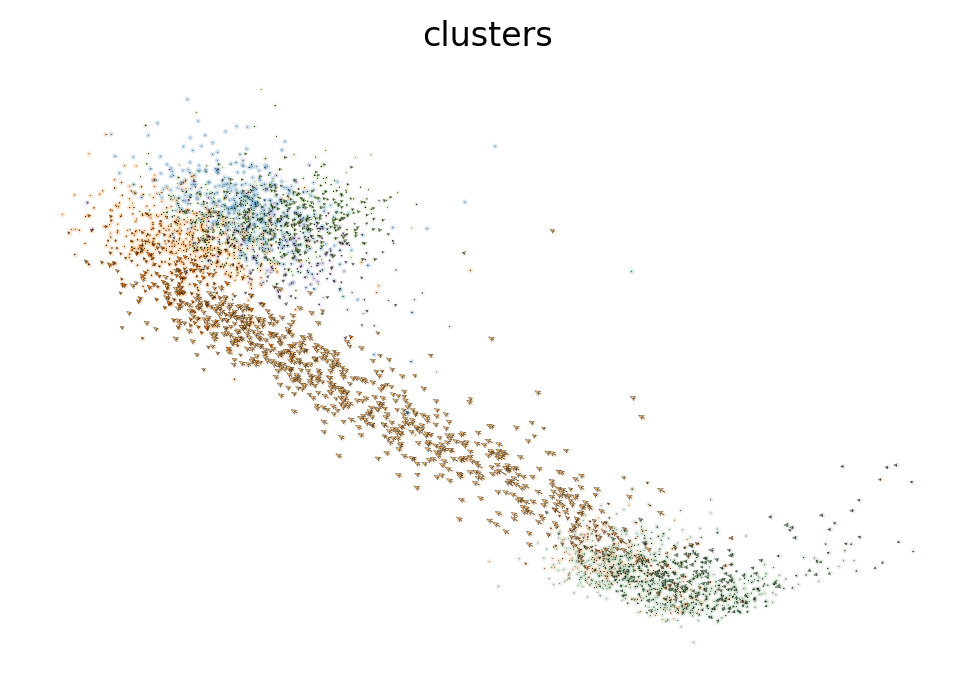

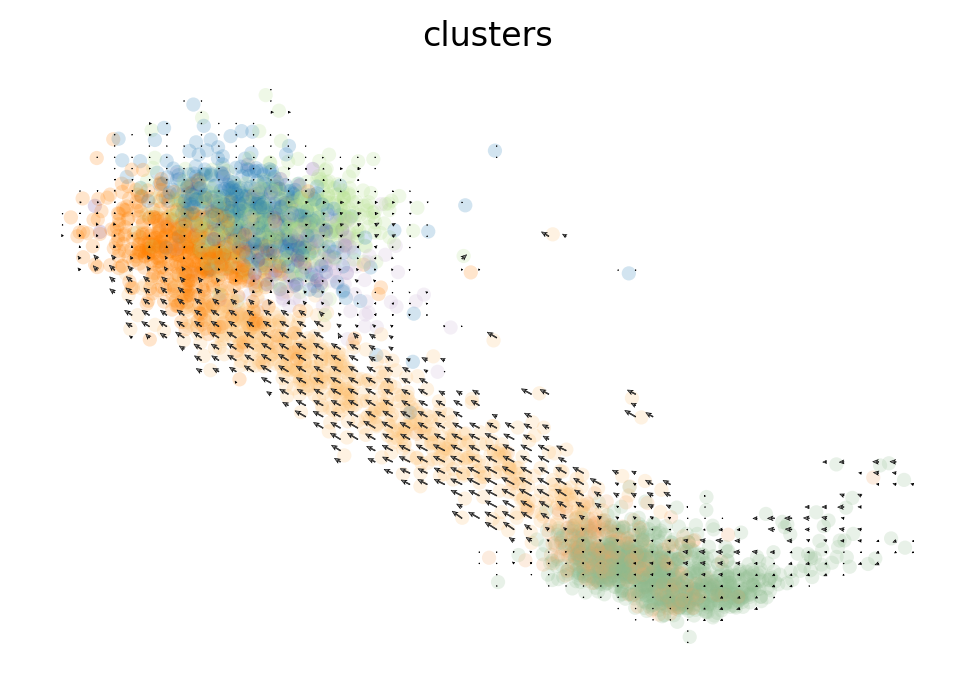

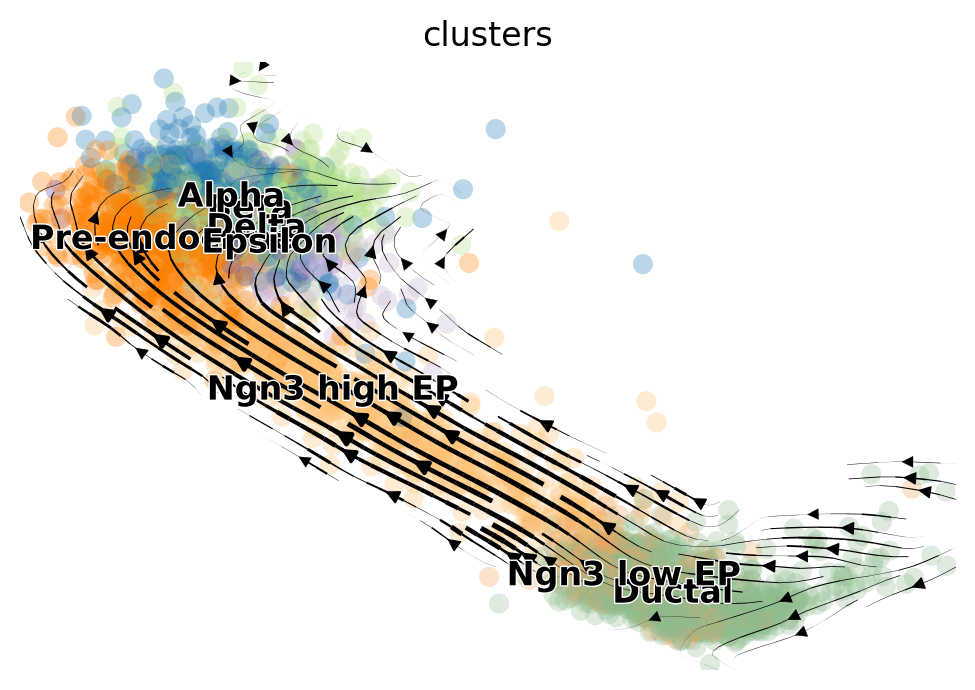

In [ ]:
scv.pl.velocity_embedding(adata, basis='pca')
scv.pl.velocity_embedding_grid(adata, basis='pca')
scv.pl.velocity_embedding_stream(adata, basis='pca')

In [ ]:
cluster_set = set(adata.obs["clusters"])
print(len(cluster_set))

8


In [ ]:
d = {}
for c in cluster_set:
    d[c] = c

pranc_clusters = []
for i in range(len(adata.obs["clusters"])):
    pranc_clusters.append(d[adata.obs["clusters"][i]])
    
d_num = {}
count = 0
for c in cluster_set:
    d_num[c] = count
    count +=1

l = []
for i in range(len(adata.obs["clusters"])):
    l.append(d_num[adata.obs["clusters"][i]])

In [ ]:
X = torch.tensor(adata.obsm["X_pca"])
flow = torch.tensor(adata.obsm["velocity_pca"])
X = X.float().to(device)
flow = flow.float().to(device)

100%|██████████| 2000/2000 [00:23<00:00, 84.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Exiting training with loss  tensor(30118.6855, device='cuda:0', grad_fn=<AddBackward0>)


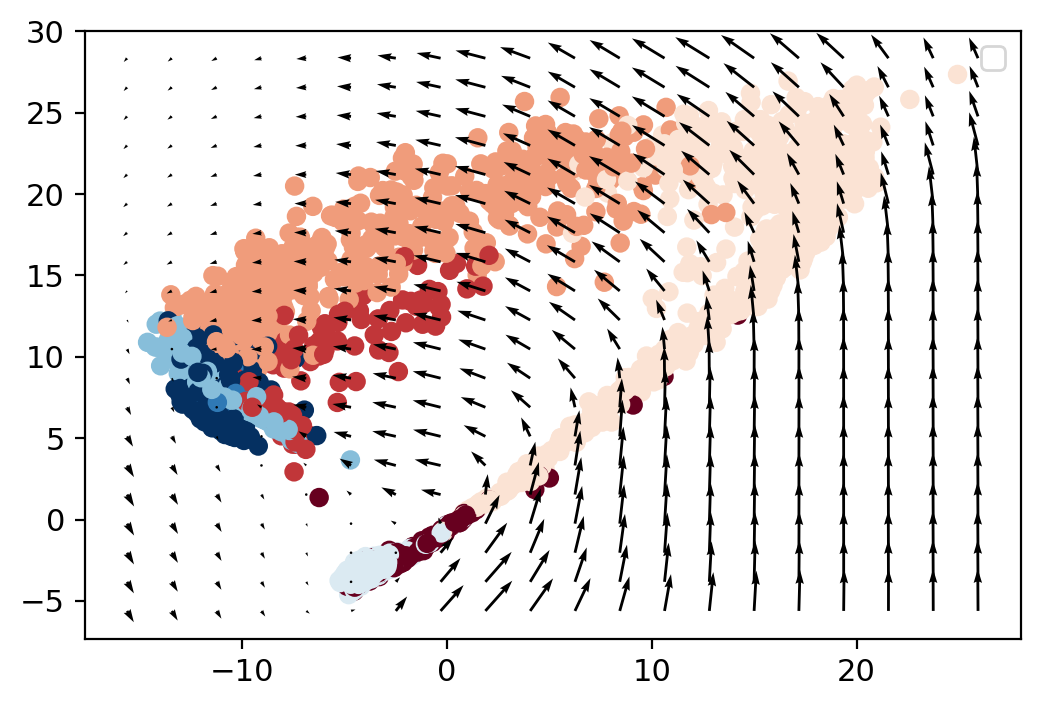

In [ ]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)
dfe.visualize_points(l)

In [ ]:
def visualize_KLD_loss(losses):
    l = losses
    x = [i in range(len(l))]
    y = [row[0].cpu().detach().numpy() for row in l]
    plt.plot(y)
    
def visualize_AE_loss(losses):
    l = losses
    x = [i in range(len(l))]
    y = [row[1].cpu().detach().numpy() for row in l]
    plt.plot(y)

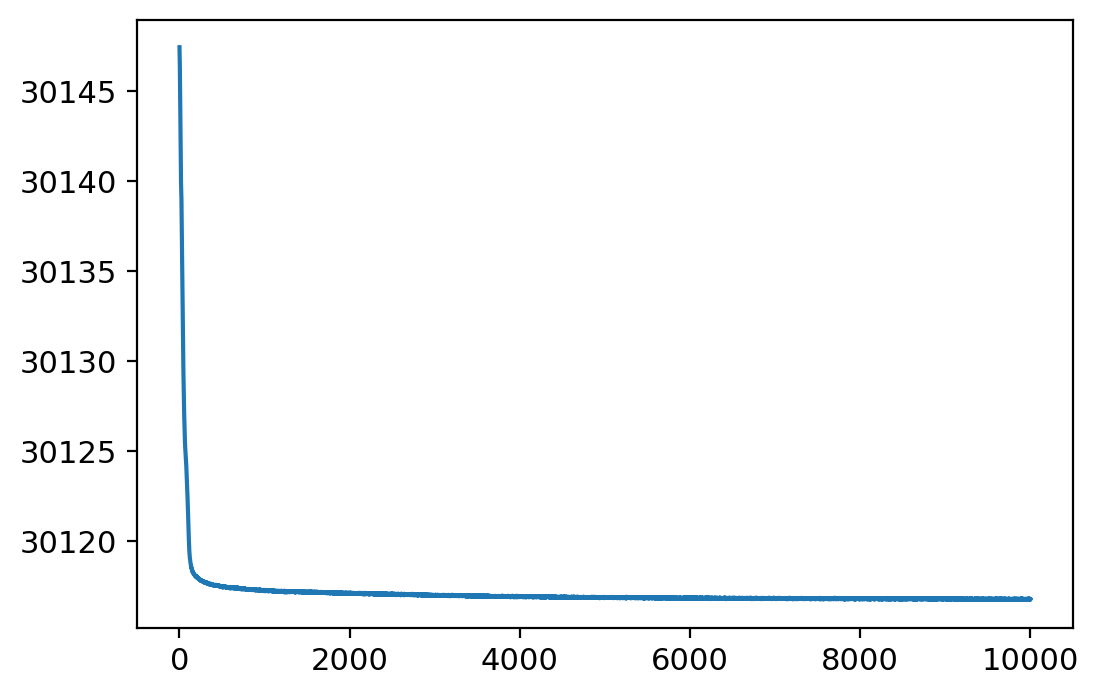

In [ ]:
visualize_KLD_loss(dfe.losses)

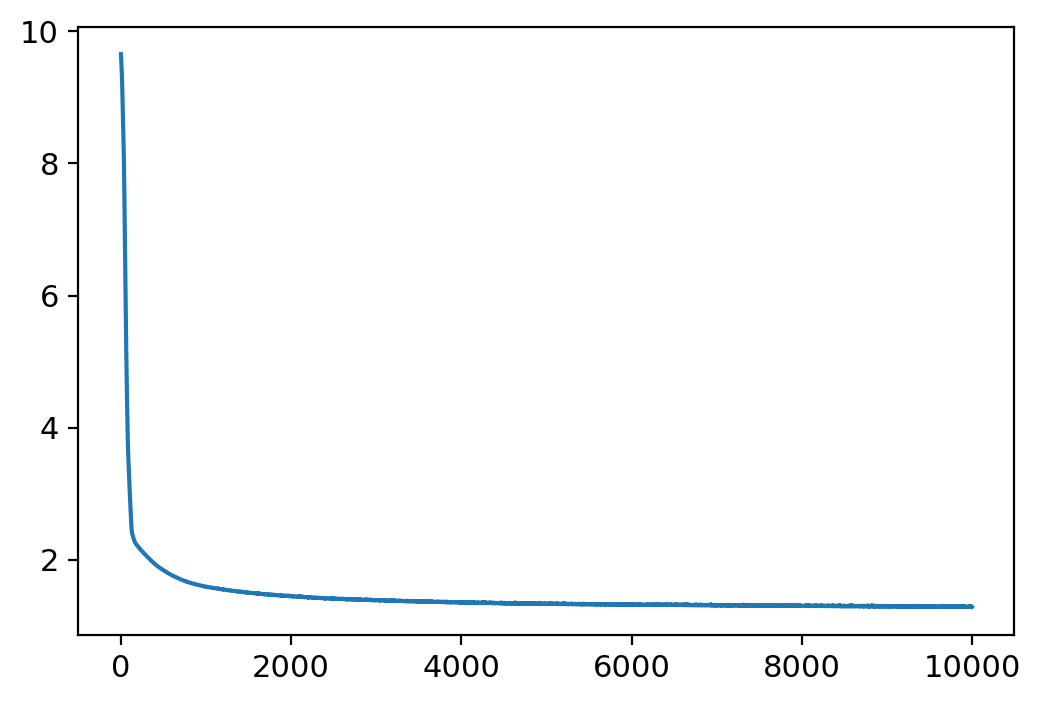

In [ ]:
visualize_AE_loss(dfe.losses)